In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("merged_traffic_data.csv")

In [3]:
#Generating new col for day of the week
df['date'] = pd.to_datetime(df['date'])

#Extract week day from the date column
df['day_of_week'] = df['date'].dt.weekday

#Create a column to indicate whether speeding occurred. This will be our target variable
df['is_speeding'] = df['maximum_speed'] > df['speed_limit']

#Create weekend/weekday feature
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

#Create month feature
df['month'] = df['date'].dt.month

#Create season feature
df['season'] = pd.cut(df['date'].dt.month, bins=[0, 3, 6, 9, 12], 
                      labels=['Winter', 'Spring', 'Summer', 'Autumn'], 
                      include_lowest=True)

#Convert time to datetime
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

#Create hour col from time
df['hour'] = df['time'].dt.hour

#Create time windows
def get_time_window(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

#Create time windoww feature for different parts of day
df['time_window'] = df['hour'].apply(get_time_window)

#Adding a rush hour boolean variable
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

#Combining vehicles that are of similar class since they have limited data and appear to be of similar large size.
vehicle_classes = ['vehicle_class_3', 'vehicle_class_4', 'vehicle_class_5', 'vehicle_class_6', 
                   'vehicle_class_7', 'vehicle_class_8', 'vehicle_class_9', 'vehicle_class_10', 
                   'vehicle_class_11', 'vehicle_class_12']

#Create a new column "Heavy_Vehicles" by summing the values of vehicle classes 3 to 12
df['Heavy_Vehicles'] = df[vehicle_classes].sum(axis=1)

#Encoding Categorical Variables
le = LabelEncoder()
df['season_encoded'] = le.fit_transform(df['season'])
df['time_window_encoded'] = le.fit_transform(df['time_window'])

#Select features for the model (removing speed-related features)
features = ['vehicle_class_1', 'vehicle_class_2', 'Heavy_Vehicles', 
            'day_of_week', 'is_weekend', 'month', 'season_encoded', 
            'hour', 'time_window_encoded', 'is_rush_hour', 'suburb']

X = df[features]
y = df['is_speeding']


Tuning model: Random Forest
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Random Forest Results:
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

       False       0.84      0.87      0.85      6674
        True       0.81      0.76      0.79      4873

    accuracy                           0.83     11547
   macro avg       0.82      0.82      0.82     11547
weighted avg       0.83      0.83      0.83     11547

ROC AUC: 0.9101
Cross-validation: 0.8336 (+/- 0.0095)

Tuning model: XGBoost
Fitting 5 folds for each of 27 candidates, totalling 135 fits

XGBoost Results:
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
              precision    recall  f1-score   support

       False       0.83      0.87      0.85      6674
        True       0.81      0.76      0.79      4873

    accuracy                           0.83     11547
 

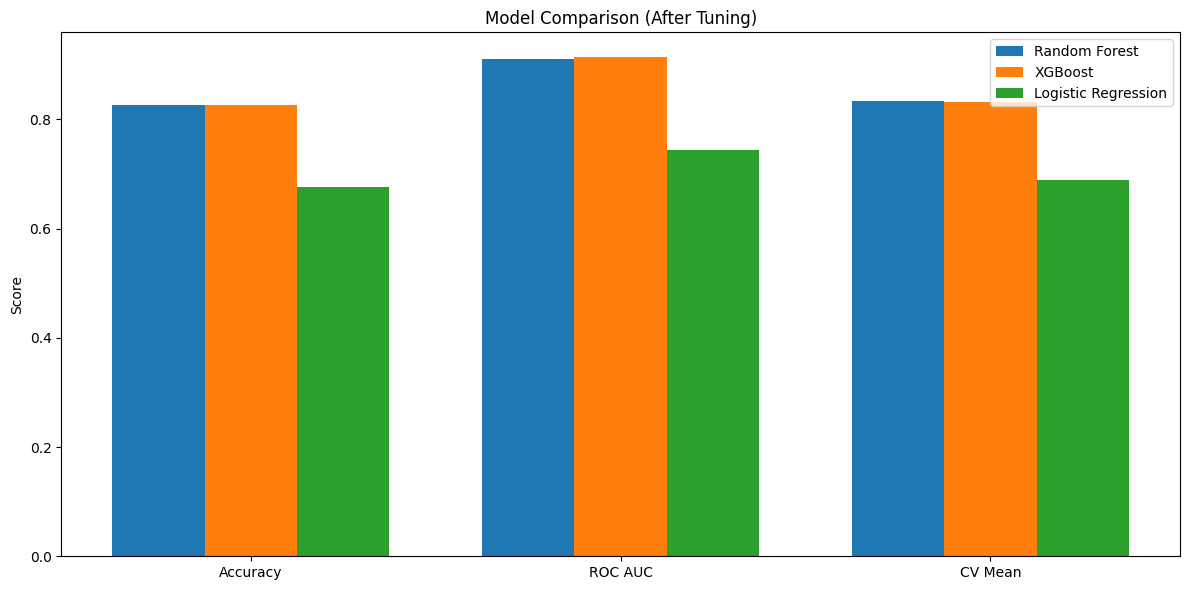


Random Forest Feature Importances:
vehicle_class_1 : 0.3078
suburb : 0.2160
Heavy_Vehicles : 0.1427
month : 0.0931
hour : 0.0766
day_of_week : 0.0520
vehicle_class_2 : 0.0340
season_encoded : 0.0338
time_window_encoded : 0.0242
is_weekend : 0.0105
is_rush_hour : 0.0095

XGBoost Feature Importances:
vehicle_class_1 : 0.2638
suburb : 0.2378
month : 0.1333
time_window_encoded : 0.0735
hour : 0.0649
season_encoded : 0.0586
day_of_week : 0.0543
Heavy_Vehicles : 0.0499
is_rush_hour : 0.0338
vehicle_class_2 : 0.0300
is_weekend : 0.0000

Logistic Regression Coefficients:
                feature  coefficient
0       vehicle_class_1     1.149362
10               suburb     0.446738
1       vehicle_class_2    -0.158088
6        season_encoded    -0.060463
8   time_window_encoded     0.052549
5                 month    -0.045942
9          is_rush_hour    -0.044161
7                  hour    -0.036216
3           day_of_week    -0.023626
4            is_weekend     0.013826
2        Heavy_Vehicle

In [4]:
#Splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Generating scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Define models parameters to find best model
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    }
}

#Train and evaluate models
results = {}
#To store the best models
best_models = {}  
for name, model_info in models.items():
    print(f"\nTuning model: {name}")
    
    #Perform GridSearchCV to find best params
    grid_search = GridSearchCV(model_info['model'], model_info['param_grid'], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)
    
    #Get and then store the best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model 
    
    #Make predictions on the test set
    y_pred = best_model.predict(X_test_scaled)
    
    #Metric calculation
    accuracy = best_model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1])
    
    #Cross validation on the best model
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)
    
    results[name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'CV Mean': np.mean(cv_scores),
        'CV Std': np.std(cv_scores),
        'Best Params': grid_search.best_params_
    }
    
    print(f"\n{name} Results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Cross-validation: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

#Visualise results of different models
metrics = ['Accuracy', 'ROC AUC', 'CV Mean']
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.25
for i, (name, model_results) in enumerate(results.items()):
    values = [model_results[metric] for metric in metrics]
    ax.bar(x + i*width, values, width, label=name)
ax.set_ylabel('Score')
ax.set_title('Model Comparison (After Tuning)')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.show()

#Print feature importances for Random Forest and XGBoost
for name in ['Random Forest', 'XGBoost']:
    if hasattr(best_models[name], 'feature_importances_'):
        importances = best_models[name].feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print(f"\n{name} Feature Importances:")
        for f, idx in enumerate(indices):
            print("{0} : {1:.4f}".format(features[idx], importances[idx]))

#Print coefficients for Logistic Regression
lr_model = best_models['Logistic Regression']
if hasattr(lr_model, 'coef_'):
    lr_coef = pd.DataFrame(
        {'feature': features, 'coefficient': lr_model.coef_[0]}
    ).sort_values('coefficient', key=abs, ascending=False)
    print("\nLogistic Regression Coefficients:")
    print(lr_coef)

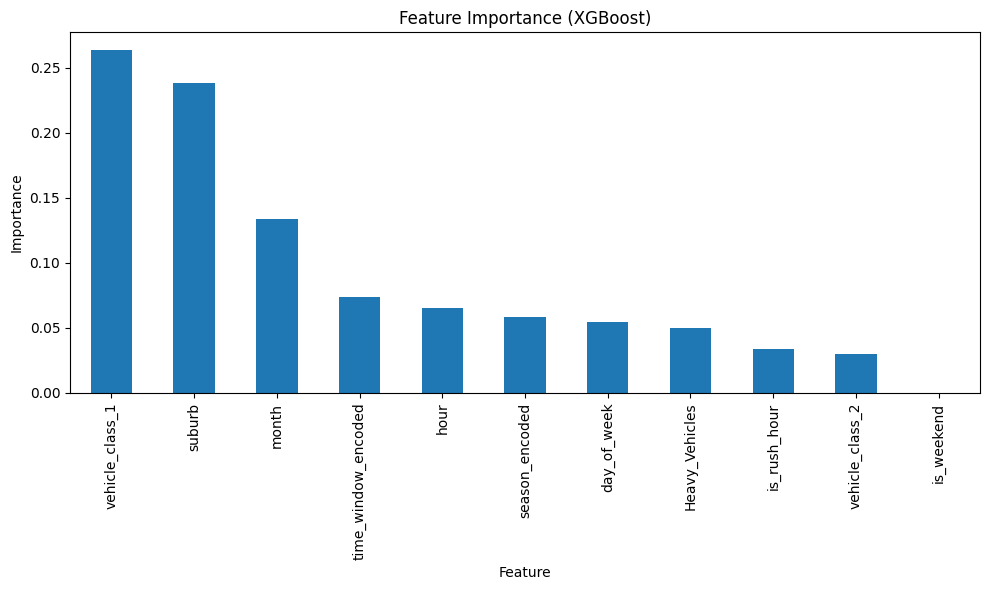

In [5]:
#Strongest model is XGBoost, relevant feature performance from best model:
best_xgb_model = best_models['XGBoost']

def visualize_bar_chart(data, title, xlabel, ylabel, color= None):
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

feature_importance = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

visualize_bar_chart(importance_df.set_index('feature')['importance'], "Feature Importance (XGBoost)", "Feature", "Importance")

In [6]:
#Load suburb mapping file for seeing suburb names
suburb_mapping_df = pd.read_csv('suburb_mapping.csv')
suburb_mapping = dict(zip(suburb_mapping_df['Encoded Value'], suburb_mapping_df['Suburb']))

#Use the best XGBoost model from previous analysis
best_xgb_model = best_models['XGBoost']

#Predict probabilities for the test set
test_probabilities = best_xgb_model.predict_proba(X_test_scaled)[:, 1]

#Create test df to have features and for adding predictions 
df_test = df.loc[X_test.index].copy()
df_test['high_speed_probability'] = test_probabilities

#Mapping from day number to day name
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

#Analyze high risk suburbs
suburb_risk = df_test.groupby('suburb')['high_speed_probability'].mean().sort_values(ascending=False)
print("Top 10 High-Risk Suburbs:")
for suburb_code, risk in suburb_risk.head(10).items():
    suburb_name = suburb_mapping.get(suburb_code, f"Unknown Suburb (Code: {suburb_code})")
    print(f"{suburb_code}: {suburb_name} - Risk: {risk:.4f}")

#Analyze high risk times
time_risk = df_test.groupby('hour')['high_speed_probability'].mean().sort_values(ascending=False)
print("\nTop 10 High-Risk Hours:")
print(time_risk.head(10))

#Analyze high risk days
day_risk = df_test.groupby('day_of_week')['high_speed_probability'].mean().sort_values(ascending=False)
print("\nDays Ranked by Risk:")
for day_code, risk in day_risk.items():
    day_name = day_mapping.get(day_code, "Unknown Day")
    print(f"{day_code}: {day_name} - Risk: {risk:.4f}")

Top 10 High-Risk Suburbs:
7: parkville - Risk: 0.6564
6: north melbourne - Risk: 0.5610
2: docklands - Risk: 0.5261
8: south yarra - Risk: 0.5123
10: west melbourne - Risk: 0.4431
5: melbourne cbd - Risk: 0.3965
0: carlton - Risk: 0.3145
4: kensington - Risk: 0.2326
9: southbank - Risk: 0.1541
1: carlton north - Risk: 0.0298

Top 10 High-Risk Hours:
hour
14    0.468579
16    0.460926
18    0.458815
9     0.449648
6     0.448228
17    0.447533
12    0.433814
10    0.431807
15    0.428855
7     0.424770
Name: high_speed_probability, dtype: float32

Days Ranked by Risk:
2: Wednesday - Risk: 0.4831
0: Monday - Risk: 0.4474
6: Sunday - Risk: 0.4106
5: Saturday - Risk: 0.4094
1: Tuesday - Risk: 0.3946
4: Friday - Risk: 0.3899
3: Thursday - Risk: 0.3855


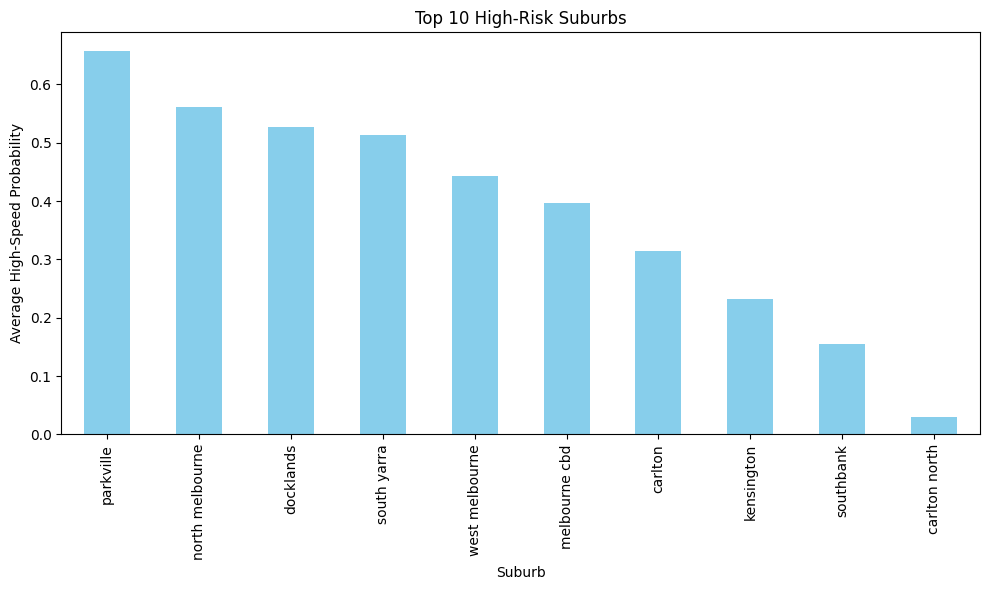

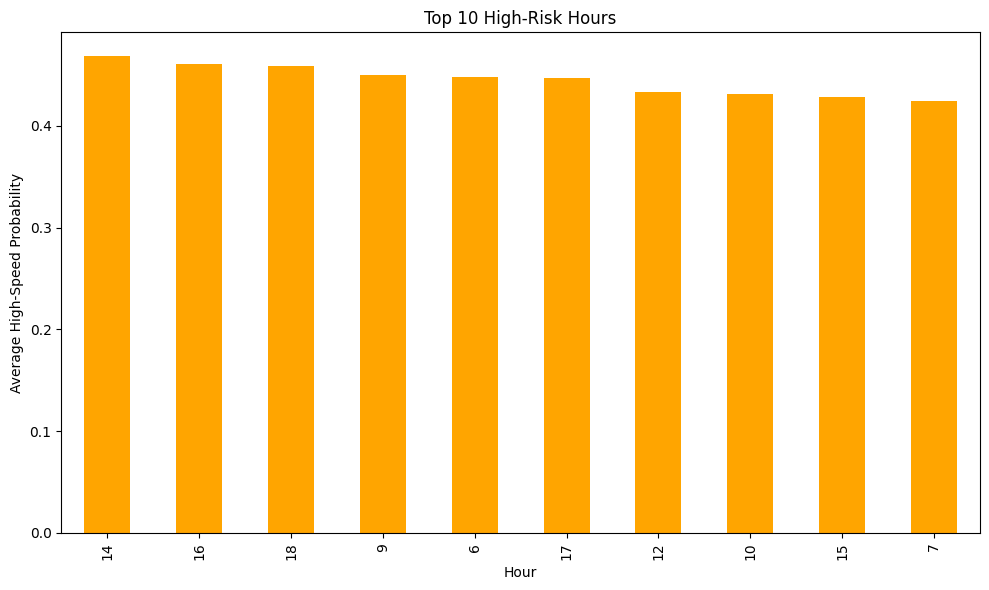

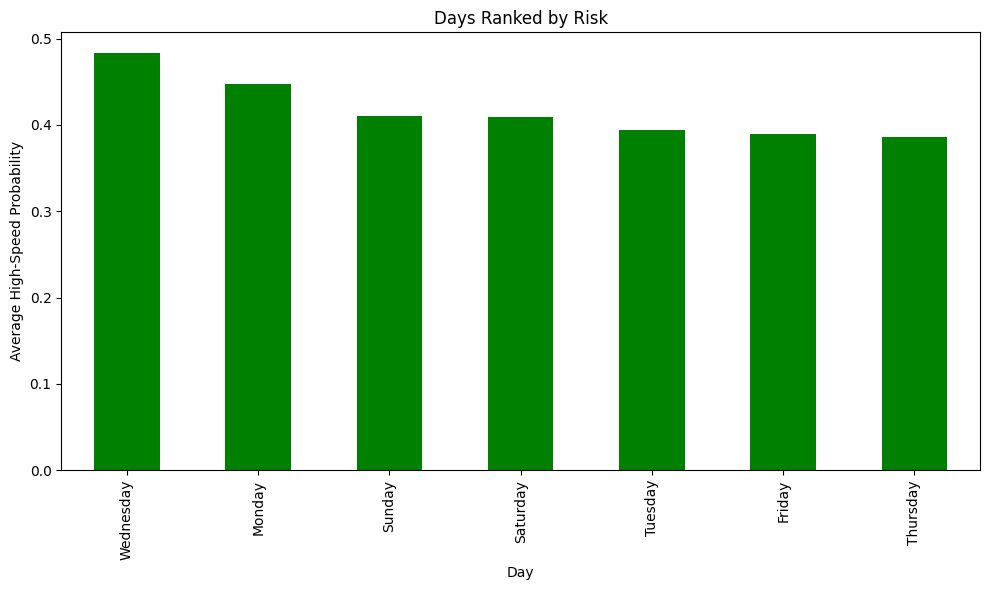

In [7]:
day_risk_sorted = day_risk.sort_values(ascending=False)
day_risk_sorted.index = day_risk_sorted.index.map(day_mapping)

suburb_risk_named = suburb_risk.head(10).index.to_series().map(suburb_mapping)


visualize_bar_chart(suburb_risk.head(10).set_axis(suburb_risk_named), "Top 10 High-Risk Suburbs", "Suburb", "Average High-Speed Probability", "skyblue")
visualize_bar_chart(time_risk.head(10), "Top 10 High-Risk Hours", "Hour", "Average High-Speed Probability", "orange")
visualize_bar_chart(day_risk_sorted, "Days Ranked by Risk", "Day", "Average High-Speed Probability", "green")

In [8]:
import folium

if not df_test.empty:
    center_lat = df_test['Latitude'].mean()
    center_lon = df_test['Longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

#Define a color scale for risk probabilities
def get_color(prob):
    if prob >= 0.8:
        return 'red'
    elif prob >= 0.6:
        return 'orange'
    elif prob >= 0.4:
        return 'yellow'
    else:
        return 'green'

#Add points for each suburb on the map using latitude and longitude from df_test
for _, row in df_test.iterrows():
    if not pd.isna(row['Latitude']) and not pd.isna(row['Longitude']):
        suburb_name = suburb_mapping.get(row['suburb'], f"Unknown Suburb (Code: {row['suburb']})")
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=10,
            color=get_color(row['high_speed_probability']),
            fill=True,
            fill_color=get_color(row['high_speed_probability']),
            fill_opacity=0.7,
            popup=f"Suburb {row['suburb']}: {suburb_name} <br>Risk: {row['high_speed_probability']:.2f}"
        ).add_to(m)

m.save("high_risk_areas.html")
